<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Practicum 2: Visual Question Answering

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

### **Team: $\alpha\beta normal$ $Distri\beta ution$**
#### **Roht Beri, Eduardo Peynetti, Jessica Wijaya, Stuart Neilson**

## Creating Pipeline for Training

### Imports

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 1.3MB 5.1MB/s 
     |████████████████████████████████| 1.1MB 19.3MB/s 
     |████████████████████████████████| 2.9MB 29.4MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5c33bf510c5e541e2d67d8f8c136a71fd83f9988d38e212d05206f258e2a5f6a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import os
import requests
import tempfile
import zipfile
import shutil
import json
import time
import sys
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from glob import glob
from google.colab import drive
from tqdm.notebook import trange, tqdm
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
from tensorflow_addons.metrics import F1Score

from transformers import BertTokenizer

from sklearn.model_selection import train_test_split

### Utils

In [ ]:
!pwd

/content


In [78]:
"""
!mkdir 'data'
#shutil.rmtree('/content/data/train2014_tf')
#shutil.rmtree('/content/data/val2014_tf')
!cp -r '/content/drive/My Drive/Practicum2Data/val2014_tf' /content/data
!cp -r '/content/drive/My Drive/Practicum2Data/train2014_tf' /content/data
!cp -r "/content/drive/My Drive/Practicum2Data/answers.csv" /content/data
"""

# https://storage.googleapis.com/practicum2-abnormal-distribution/train2014_tf
# https://storage.googleapis.com/practicum2-abnormal-distribution/val2014_tf

In [79]:
# Paths to training and validation data
PATHS_TRAIN = '/content/data/train2014_tf'
PATHS_VAL = '/content/data/val2014_tf'

# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
K = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Pipeline variables
batch_size = 64
train_buffer_size = 800
val_buffer_size = 200
prefetch = 32

In [99]:
# Get Top K answers
def get_top_K_answers(k):
    answers = pd.read_csv("/content/data/answers.csv", index_col=0)
    answers = answers.index[:k]
    return list(answers)

top_answers = get_top_K_answers(K)
top_answers = tf.constant(TOP_ANSWERS)

In [81]:
# Function to parse data features
def _parse_features_function(example):
    # Parse the input tf.train.Example proto using the dictionary above.
    tf_records_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string), 
        'question' : tf.io.FixedLenFeature([], tf.string),
        'input_ids': tf.io.FixedLenFeature([], tf.string),
        'token_type_ids': tf.io.FixedLenFeature([], tf.string),
        'attention_mask': tf.io.FixedLenFeature([], tf.string), 
        'answer': tf.io.FixedLenFeature([], tf.int64)
    }
    return tf.io.parse_single_example(example, tf_records_features)

# Filter if answer is no
def filter_fn(x):
    #use broadcasting for element-wise tensor operation
    broadcast_equal = tf.equal(TOP_ANSWERS, x['answer'])
    broadcast_equal_int = tf.cast(broadcast_equal, tf.int8)
    broadcast_sum = tf.reduce_sum(broadcast_equal_int)
    return broadcast_sum > 0

# Read image and resize it
def read_and_resize(img):
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.cast(img, tf.float32)/255.0
    return img

# Structure the data for training
def structure_data(data):
    image = data['image_raw']
    image = read_and_resize(image)
    
    input_ids = tf.io.decode_raw(data['input_ids'], tf.int32)
    token_type_ids = tf.io.decode_raw(data['token_type_ids'], tf.int32)
    attention_mask = tf.io.decode_raw(data['attention_mask'], tf.int32)
    
    answer = data['answer']

    return ((image, (input_ids, token_type_ids, attention_mask)), answer)


### Build Pipeline

In [92]:
# ############## #
# # Train data # #
# ############## #
tfrecords_pattern_path = "/content/data/train2014_tf/vaq_raw_train2014_*-of-*.records"
train_files = tf.io.matching_files(tfrecords_pattern_path)
train_files = tf.random.shuffle(train_files)
train_shards = tf.data.Dataset.from_tensor_slices(train_files)

train = train_shards.interleave(tf.data.TFRecordDataset)
train = train.map(_parse_features_function, num_parallel_calls=AUTOTUNE)
#train = train.filter(filter_fn)
train = train.map(structure_data, num_parallel_calls=AUTOTUNE)
train = train.shuffle(buffer_size=train_buffer_size).batch(batch_size)
train = train.cache().prefetch(prefetch)

# ################### #
# # Validation data # #
# ################### #
tfrecords_pattern_path = "/content/data/val2014_tf/vaq_raw_val2014_*-of-*.records"
val_files = tf.io.matching_files(tfrecords_pattern_path)
val_files = tf.random.shuffle(val_files)
val_shards = tf.data.Dataset.from_tensor_slices(val_files)

valid = val_shards.interleave(tf.data.TFRecordDataset)

valid = valid.map(_parse_features_function, num_parallel_calls=AUTOTUNE)
#valid = valid.filter(filter_fn)
valid = valid.map(structure_data, num_parallel_calls=AUTOTUNE)
valid = valid.shuffle(buffer_size=val_buffer_size).batch(batch_size)
valid = valid.cache().prefetch(prefetch)

In [93]:
train

<PrefetchDataset shapes: (((None, None, None, 3), ((None, None), (None, None), (None, None))), (None,)), types: ((tf.float32, (tf.int32, tf.int32, tf.int32)), tf.int64)>

In [94]:
valid

<PrefetchDataset shapes: (((None, None, None, 3), ((None, None), (None, None), (None, None))), (None,)), types: ((tf.float32, (tf.int32, tf.int32, tf.int32)), tf.int64)>

In [95]:
print(val_files)

tf.Tensor(
[b'/content/data/val2014_tf/vaq_raw_val2014_08-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_09-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_10-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_02-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_05-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_00-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_07-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_06-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_01-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_03-of-10.records'
 b'/content/data/val2014_tf/vaq_raw_val2014_04-of-10.records'], shape=(11,), dtype=string)


tf.Tensor(
[ 101 2003 2023 1999 1037 9201 1029  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(24,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(24,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(24,), dtype=int32)
yes
tf.Tensor(0, shape=(), dtype=int64)


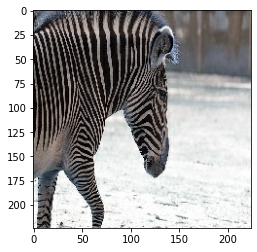

In [117]:
for item in valid.take(1):
    print(item[0][1][0][0])
    print(item[0][1][1][0])
    print(item[0][1][2][0])
    plt.imshow(item[0][0][0])
    print(top_answers[item[1][0]].numpy().decode('utf-8'))
    print(item[1][0])